## Create a system with dilute units

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as plticker
# %matplotlib notebook
# %load_ext autoreload
# %autoreload 2

import pickle as pkl
import pandas as pd
import scipy as sp
from scipy import spatial
import os.path as path


import autograd.numpy as np   
# import numpy as np
from autograd.misc.flatten import flatten_func
from autograd import grad as compute_grad

import sys
sys.path.append('./py_packages/')
import BuildNetwork as net
import fixedend_sys_funcs

### Voronoi network

In [5]:
def get_mesh(num_mesh=100, Lx=20, Ly=20):
    mesh_x_ls = np.linspace(-Lx/2, Lx/2, num_mesh)
    mesh_y_ls = np.linspace(-Ly/2, Ly/2, num_mesh)
    mesh_x, mesh_y = np.meshgrid(mesh_x_ls, mesh_y_ls)
    mesh_xy = np.column_stack([mesh_x.flatten(), mesh_y.flatten()])
    return mesh_x, mesh_y, mesh_xy

def find_indices(array, condition):
    """Returns array indicies when condition is true.
    """
    ind = []
    for i,val in enumerate(array):
        if condition(val):
            ind.append(i)
    return ind

def calc_region_centroid(reg_no, mesh_x, mesh_y):
    ind_region = find_indices(min_dist_no, lambda e: e == reg_no)
    cx = np.mean(mesh_x.flatten()[ind_region])
    cy = np.mean(mesh_y.flatten()[ind_region])
    return cx, cy

In [6]:
# l0
num_pts = 100
num_dim = 2
size_Lx = 40
size_Ly = 40

# # 2l0
# num_pts = 100
# num_dim = 2
# size_Lx = 80
# size_Ly = 80

# # 0.5l0
# num_pts = 100
# num_dim = 2
# size_Lx = 15
# size_Ly = 15

# random pts
x = (np.random.rand(num_pts)-0.5)*size_Lx*0.95
y = (np.random.rand(num_pts)-0.5)*size_Ly*0.95
points = np.column_stack([x,y])

vor = sp.spatial.Voronoi(points)

num_mesh = 400
mesh_x, mesh_y, mesh_xy = get_mesh(num_mesh, size_Lx, size_Ly)

# calculate distance between points and mesh_xy
# assign each grid pt to a random generated point based on the distance
dist_mesh_point = sp.spatial.distance.cdist(mesh_xy,points)
min_dist_no = np.argmin(dist_mesh_point,axis = 1) + 1
mesh_to_region_no = min_dist_no.reshape([num_mesh,num_mesh])

cx = []
cy = []
for region_num in range(1, num_pts+1):
    reg_cx, reg_cy = calc_region_centroid(region_num, mesh_x, mesh_y)
    cx.append(reg_cx)
    cy.append(reg_cy)
    
# Lloyd relaxation on coarse mesh
num_mesh = 200
num_iter = 20

mesh_x, mesh_y, mesh_xy = get_mesh(num_mesh, Lx=size_Lx, Ly=size_Ly)
ref_points = points
for i in range(num_iter):  
    dist_mesh_point = sp.spatial.distance.cdist(mesh_xy,ref_points)
    min_dist_no = np.argmin(dist_mesh_point,axis = 1) + 1
    mesh_to_region_no = min_dist_no.reshape([num_mesh,num_mesh])
    
    cx = []
    cy = []
    for region_num in range(1, num_pts+1):
        reg_cx, reg_cy = calc_region_centroid(region_num, mesh_x, mesh_y)
        cx.append(reg_cx)
        cy.append(reg_cy)    
    ref_points = np.column_stack([cx, cy])
    
# Lloyd relaxation on finer mesh
num_mesh = 400
num_iter = 5

mesh_x, mesh_y, mesh_xy = get_mesh(num_mesh, Lx=size_Lx, Ly=size_Ly)
ref_points = ref_points
for i in range(num_iter):
    dist_mesh_point = sp.spatial.distance.cdist(mesh_xy,ref_points)
    min_dist_no = np.argmin(dist_mesh_point,axis = 1) + 1
    mesh_to_region_no = min_dist_no.reshape([num_mesh,num_mesh])
    cx = []
    cy = []
    for region_num in range(1, num_pts+1):
        reg_cx, reg_cy = calc_region_centroid(region_num, mesh_x, mesh_y)
        cx.append(reg_cx)
        cy.append(reg_cy)    
    ref_points = np.column_stack([cx, cy])

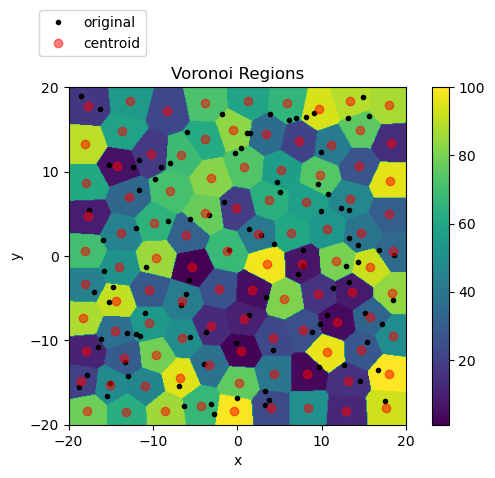

In [7]:
fig = plt.figure(figsize=[6,5])
ax = fig.add_subplot(1,1,1)
plt.imshow(np.flipud(mesh_to_region_no), extent=[-size_Lx/2,size_Lx/2,-size_Ly/2,size_Ly/2], aspect='equal')
plt.yticks(np.linspace(-size_Lx/2,size_Lx/2,5))
plt.xticks(np.linspace(-size_Ly/2,size_Ly/2,5))
plt.plot(x, y, '.', color='k', label='original')
plt.plot(cx, cy, 'ro', alpha=0.5, label='centroid')
plt.colorbar(fraction=0.037, pad=0.05)
plt.legend(loc='upper right', bbox_to_anchor=(0.25, 1.25))
ax.set_aspect('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Voronoi Regions')
plt.tight_layout()
plt.show()

In [8]:
cmap = sp.spatial.distance.cdist(ref_points, ref_points)

In [9]:
np.min(cmap[np.where(cmap>0)]) # needs to be slightly larger than l0

3.3788627993393394

In [10]:
np.max(cmap)

50.99259492261743

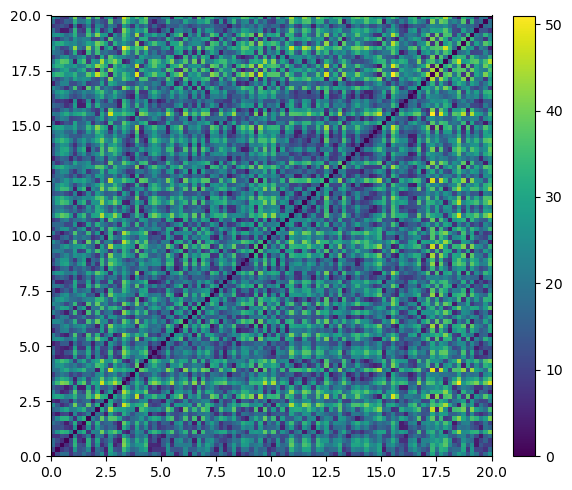

In [11]:
fig = plt.figure(figsize=[6,5])
ax = fig.add_subplot(1,1,1)
# array number grows in a way opposite to the Cartesian coordiante, np.filpud makes them grow in the same way
plt.imshow(np.flipud(cmap), extent=[0,20,0,20], aspect='equal')
plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

### Random system from Voronoi network

In [12]:
magr = 1/16*2.54 # 1/16 inch magnet (cm)
lo = 2.0 # spring initial length (cm)
netlen = lo + 2*magr*0

# assign magnetic dipole moment magnitude/strength to selected nodes
mu0 = 4*np.pi*1e-7    # permeability of vacuum (H/m), H = J/A2
Br = 1.31 # in T (~N42)
M = Br/mu0    # magnetization (A/m)
# magnet shape (assume height and width are both 1/16 in.)
Rm = magr*10    # in mm
tm = 0.25*25.4   # in mm
V = (tm/1000)*np.pi*(Rm/1000)**2    # bar magnet volume (m3)
mag_amp = M*V  # magnet moment (A*m2)  
mag_mass = 0.377/1000  # in kg (from K&J magnet spec.s)
# moment of inertia of cylinder: I = 1/2*m*R^2
mag_J = 0.5*mag_mass*(magr/100)**2 # in kg*m^2

k = 10000

In [13]:
# smashed points (2D)
ptsset = []
for cpt in ref_points:
    originline = np.array([[-netlen/2, 0], [netlen/2, 0]])
    rot = 2*np.pi*np.random.rand()
    rot_mat = np.array([[np.cos(rot), -np.sin(rot)], [np.sin(rot), np.cos(rot)]])
    originline = originline@rot_mat
    originline = originline + cpt
    ptsset.append(originline)
    
ptsset = np.array(ptsset)
ptsset = ptsset.reshape([len(ref_points)*2, 2])
rots = np.array([2*np.pi*np.random.rand() - np.pi for i in range(len(ptsset))])

# connectivity
conn = np.arange(len(ref_points)*2).reshape([len(ref_points), 2])

# adjagency
adj = np.zeros([len(ptsset),len(ptsset)])
for pair in conn:
    adj[pair[0], pair[1]] = 1
    adj[pair[1], pair[0]] = 1

# edge list
smashed_edge_df = net.get_edges2D(adj, ptsset, stiff=k)
smashed_edge_dict = net.get_edge_dict(smashed_edge_df.reset_index().set_index('index'))

In [14]:
smashed_edge_df

,edge,i,j,bx,by,k,d
index,,,,,,,
0,"[0, 1]",0.0,1.0,0.410581,-0.911824,10000.0,2.0
1,"[2, 3]",2.0,3.0,-0.905004,-0.425402,10000.0,2.0
2,"[4, 5]",4.0,5.0,-0.181272,0.983433,10000.0,2.0
3,"[6, 7]",6.0,7.0,-0.418106,0.908398,10000.0,2.0
4,"[8, 9]",8.0,9.0,-0.889218,0.457483,10000.0,2.0
...,...,...,...,...,...,...,...
95,"[190, 191]",190.0,191.0,0.986398,-0.164373,10000.0,2.0
96,"[192, 193]",192.0,193.0,-0.772815,0.634632,10000.0,2.0
97,"[194, 195]",194.0,195.0,0.961030,0.276443,10000.0,2.0


In [15]:
origin_net_info = {}
origin_net_info['connec'] = conn
origin_net_info['points'] = ptsset
origin_net_info['rots'] = rots
origin_net_info['df'] = smashed_edge_df

In [16]:
poss = np.hstack([ptsset, np.zeros([len(rots),1])])
magrs = np.array([magr]*len(poss))
tms = np.array([tm]*len(poss))
Brs = np.array([Br]*len(poss))

In [17]:
distances = sp.spatial.distance.cdist(poss, poss)

for i in range(len(distances)):
    distances[i,i] = np.inf

np.min(distances)

1.4905195986456292

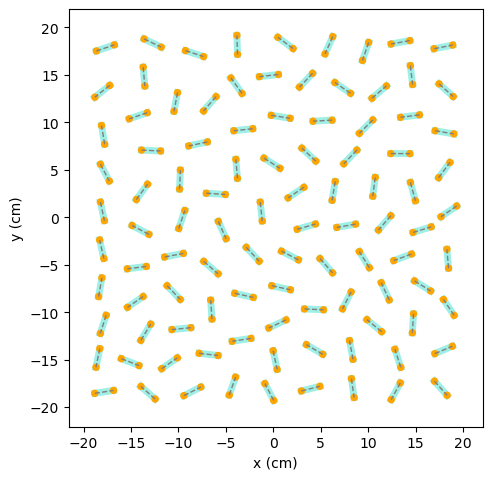

In [18]:
fixedend_sys_funcs.plot_multi_discs(poss, rots, magrs, conn, circlescale=2.0, shiftscale=0.1, wbold=5, 
                               size=[5,5], arrowlw=1.5, arrowscale=40.0, arrowheadwidth=0.2, 
                               arrowheadlength=.5, arrowalpha=0., shownodenum=False, nodesize=0)
# plt.savefig(f'origin_net_info-rand.png', dpi=200)

In [19]:
pkl.dump(origin_net_info, open(f'origin_net_info-rand', 'wb'))

### Assign end dipoles to nodes.

In [20]:
def get_dipoles(poss, conn, phis):

    end_rot = np.zeros(len(poss))

    for thisconn in conn:
        thisconn.sort()
        ni = thisconn[0]
        nj = thisconn[1]
        temp = poss[nj] - poss[ni]
        temp = temp/np.linalg.norm(temp)

        phi = phis[ni]
        rotmat = np.array([[np.cos(phi), -np.sin(phi), 0],[np.sin(phi), np.cos(phi), 0], [0, 0, 1]])
        end_rot[ni] = np.arctan2((temp@rotmat)[1], (temp@rotmat)[0])

        phi = phis[nj]
        rotmat = np.array([[np.cos(phi), -np.sin(phi), 0],[np.sin(phi), np.cos(phi), 0], [0, 0, 1]])
        end_rot[nj] = np.arctan2((temp@rotmat)[1], (temp@rotmat)[0])
        
    return end_rot

In [21]:
ang_to_choose = {}

# 0 degree
ang1 = 0*np.pi
ang2 = np.pi
ang3 = 2*np.pi
ang4 = 3*np.pi
ang_to_choose['0'] = np.array([ang1, ang2, ang3, ang4])

# 10 degree
ang1 = np.pi/18
ang2 = 17*np.pi/18
ang3 = 19*np.pi/18
ang4 = 35*np.pi/18
ang_to_choose['10'] = np.array([ang1, ang2, ang3, ang4])

# 20 degree
ang1 = np.pi/9
ang2 = 8*np.pi/9
ang3 = 10*np.pi/9
ang4 = 17*np.pi/9
ang_to_choose['20'] = np.array([ang1, ang2, ang3, ang4])

# 30 degree
ang1 = np.pi/6
ang2 = 5*np.pi/6
ang3 = 7*np.pi/6
ang4 = 11*np.pi/6
ang_to_choose['30'] = np.array([ang1, ang2, ang3, ang4])

# 40 degree
ang1 = np.pi/4.5
ang2 = 3.5*np.pi/4.5
ang3 = 5.5*np.pi/4.5
ang4 = 8*np.pi/4.5
ang_to_choose['40'] = np.array([ang1, ang2, ang3, ang4])

# 45 degree
ang1 = np.pi/4
ang2 = 3*np.pi/4
ang3 = 5*np.pi/4
ang4 = 7*np.pi/4
ang_to_choose['45'] = np.array([ang1, ang2, ang3, ang4])

# 50 degree
ang1 = np.pi/3.6
ang2 = 2.6*np.pi/3.6
ang3 = 4.6*np.pi/3.6
ang4 = 6.2*np.pi/3.6
ang_to_choose['50'] = np.array([ang1, ang2, ang3, ang4])

# 60 degree
ang1 = np.pi/3
ang2 = 2*np.pi/3
ang3 = 4*np.pi/3
ang4 = 5*np.pi/3
ang_to_choose['60'] = np.array([ang1, ang2, ang3, ang4])

# 70 degree
ang1 = 70/180*np.pi
ang2 = (180-70)/180*np.pi
ang3 = (180+70)/180*np.pi
ang4 = (360-70)/180*np.pi
ang_to_choose['70'] = np.array([ang1, ang2, ang3, ang4])

# 80 degree
ang1 = np.pi/2.25
ang2 = 1.25*np.pi/2.25
ang3 = 3.25*np.pi/2.25
ang4 = 3.5*np.pi/2.25
ang_to_choose['80'] = np.array([ang1, ang2, ang3, ang4])

# 90 degree
ang1 = np.pi/2
ang2 = 3*np.pi/2
ang3 = np.pi/2
ang4 = 3*np.pi/2
ang_to_choose['90'] = np.array([ang1, ang2, ang3, ang4])

In [22]:
# modify the desired angle here
thisdeg='90'

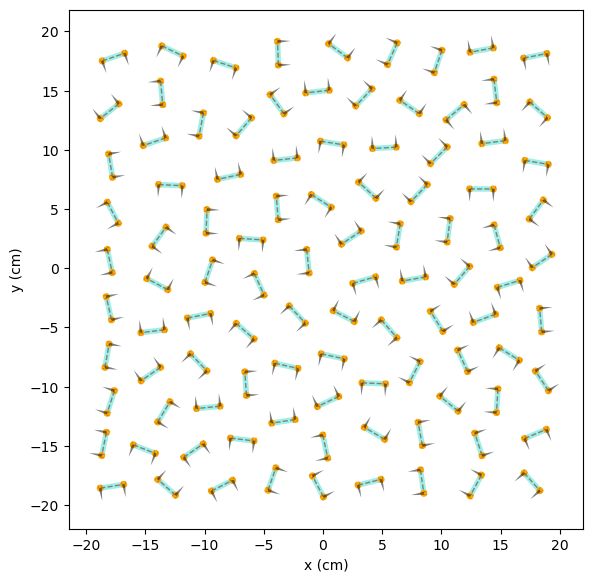

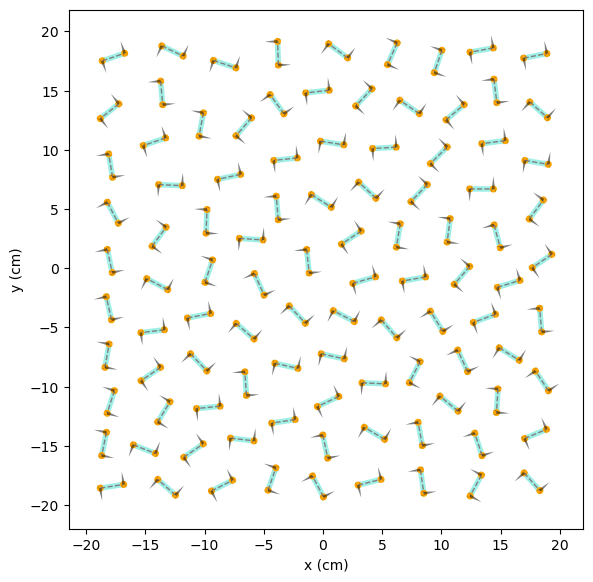

In [27]:
if thisdeg=='0':
    uni_combo = [(0,0), (0,1), (1,0)]
elif thisdeg=='90':
    uni_combo = [(0,0), (0,1)]
else:
    uni_combo = [(0,2), (0,1), (2,3), (1,3), (0,0), (0,3)] # for thisdeg!=0, 90

ind = 1
for (end1,end2) in uni_combo:
    thisname = f'{thisdeg}-{ind}'
    origin_net_info = pkl.load(open(f'origin_net_info-rand', 'rb'))
    pts_copy = origin_net_info['points'].copy()

    magr = 1/16*2.54 # 1/16 inch magnet (cm)
    lo = 2.0 # spring initial length (cm)
    netlen = lo + 2*magr*0
    # assign magnetic dipole moment magnitude/strength to selected nodes
    mu0 = 4*np.pi*1e-7    # permeability of vacuum (H/m), H = J/A2
    Br = 1.31 # in T (~N42)
    M = Br/mu0    # magnetization (A/m)
    # magnet shape (assume height and width are both 1/16 in.)
    Rm = magr*10    # in mm
    tm = 0.25*25.4   # in mm
    V = (tm/1000)*np.pi*(Rm/1000)**2    # bar magnet volume (m3)
    mag_amp = M*V  # magnet moment (A*m2)  
    mag_mass = 0.377/1000  # in kg (from K&J magnet spec.s)
    # moment of inertia of cylinder: I = 1/2*m*R^2
    mag_J = 0.5*mag_mass*(magr/100)**2 # in kg*m^2

    conn = origin_net_info['connec']
    rots = origin_net_info['rots']
    poss = np.hstack([origin_net_info['points'], np.zeros([len(rots),1])])
    lo = origin_net_info['df'][['d']].to_numpy().astype(float)
    magrs = np.array([magr]*len(poss))
    tms = np.array([tm]*len(poss))
    Brs = np.array([Br]*len(poss))

    ### control end dipole orientation
    phis =  np.vstack([ang_to_choose[thisdeg][end1].repeat([len(poss)//2]), 
                       ang_to_choose[thisdeg][end2].repeat([len(poss)//2])]).T.flatten()
    end_rot = get_dipoles(poss, conn, phis)
    test_sys = fixedend_sys_funcs.multi_disc_system(magrs, tms/10, Brs, end_rot, poss, conn, lo, eps=3e1,
                                                        k=10000, dc=magr*2, krep=50000, kang=1000.0)
    fixedend_sys_funcs.plot_multi_discs(poss, end_rot, test_sys.magrs, test_sys.connec, circlescale=1.5, 
                                             shiftscale=0.1, wbold=4, size=[6,6], arrowlw=2, arrowscale=40.0, 
                                             arrowheadwidth=0.5, arrowheadlength=2, arrowalpha=0.5, 
                                             shownodenum=False, nodesize=0)

    plt.tight_layout()
    plt.savefig(f'origin_net_info-{thisname}.png', dpi=200)
    plt.close()

    # adjagency
    adj = np.zeros([len(pts_copy),len(pts_copy)])
    for pair in conn:
        adj[pair[0], pair[1]] = 1
        adj[pair[1], pair[0]] = 1

    # edge list
    smashed_edge_df = net.get_edges2D(adj, pts_copy, stiff=10000.0)

    origin_net_info = {}
    origin_net_info['connec'] = conn
    origin_net_info['points'] = pts_copy
    origin_net_info['rots'] = end_rot ##
    origin_net_info['df'] = smashed_edge_df

    pkl.dump(origin_net_info, open(f'origin_net_info-{thisname}', 'wb'))

    ind += 1

### Read one saved network.

In [28]:
thisname = '90-1'

In [29]:
origin_net_info = pkl.load(open(f'origin_net_info-{thisname}', 'rb'))

In [30]:
magr = 1/16*2.54 # 1/16 inch magnet (cm)
lo = 2.0 # spring initial length (cm)
netlen = lo + 2*magr*0

# assign magnetic dipole moment magnitude/strength to selected nodes
mu0 = 4*np.pi*1e-7    # permeability of vacuum (H/m), H = J/A2
Br = 1.31 # in T (~N42)
M = Br/mu0    # magnetization (A/m)
# magnet shape (assume height and width are both 1/16 in.)
Rm = magr*10    # in mm
tm = 0.25*25.4   # in mm
V = (tm/1000)*np.pi*(Rm/1000)**2    # bar magnet volume (m3)
mag_amp = M*V  # magnet moment (A*m2)  
mag_mass = 0.377/1000  # in kg (from K&J magnet spec.s)
# moment of inertia of cylinder: I = 1/2*m*R^2
mag_J = 0.5*mag_mass*(magr/100)**2 # in kg*m^2

In [31]:
conn = origin_net_info['connec']
rots = origin_net_info['rots']
poss = np.hstack([origin_net_info['points'], np.zeros([len(rots),1])])

lo = origin_net_info['df'][['d']].to_numpy().astype(float)
magrs = np.array([magr]*len(poss))
tms = np.array([tm]*len(poss))
Brs = np.array([Br]*len(poss))

In [32]:
test_sys = fixedend_sys_funcs.multi_disc_system(magrs, tms/10, Brs, rots, poss, conn, lo, eps=3e1, 
                                                k=origin_net_info['df'][['k']].iloc[0].to_numpy().astype(float)[0],
                                                dc=magr*2, krep=50000, kang=1000.0)

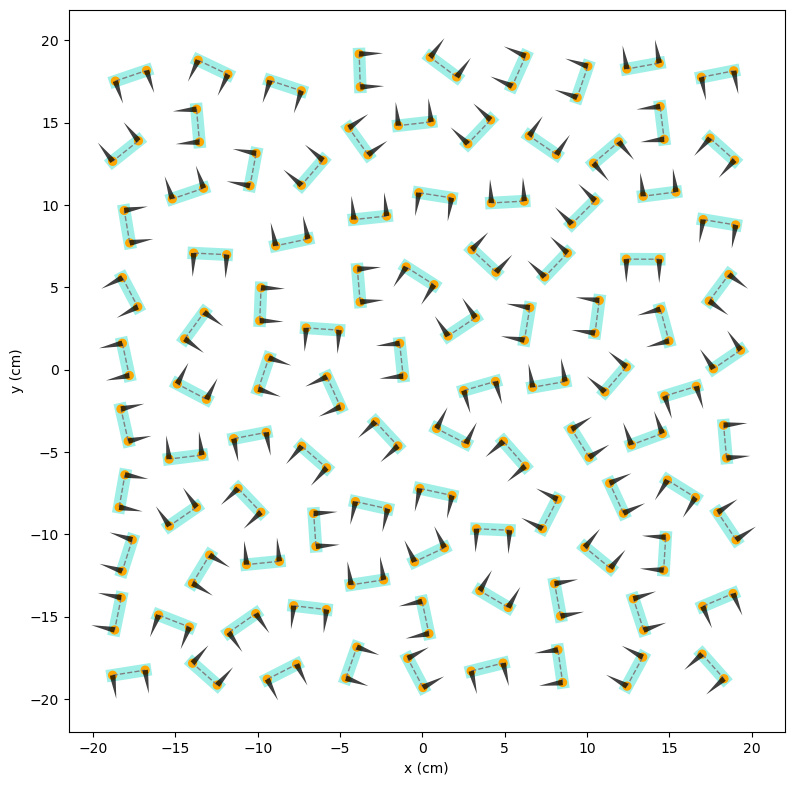

In [33]:
fixedend_sys_funcs.plot_multi_discs(poss, rots, test_sys.magrs, test_sys.connec, circlescale=1.5, shiftscale=0.1, 
                               wbold=9, size=[8,8], arrowlw=2, arrowscale=30.0, arrowheadwidth=1., 
                               arrowheadlength=4, arrowalpha=0.75, shownodenum=False, nodesize=0)